# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In addition to price data, constructing a market prior requires market-caps. 

In [2]:
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
stock_path = Path("../Resources/stock_prices.csv")
stock_prices = pd.read_csv(stock_path, infer_datetime_format = True, parse_dates = True, index_col = "Date")

In [4]:
crypto_path = Path("../Resources/crypto_prices.csv")
crypto_prices = pd.read_csv(crypto_path, infer_datetime_format = True, parse_dates = True, index_col = "Date")

In [17]:
prices = stock_prices.join(crypto_prices)

In [18]:
market_path = Path("../Resources/market_caps.csv")
market_caps = pd.read_csv(market_path)

In [19]:
market_caps

,Ticker,Market_Cap
0,SPY,"37,267,249,440,000.00"
1,GME,"14,821,737,472.00"
2,AMC,"7,389,094,912.00"
3,TSLA,"582,516,015,104.00"
4,BB,"4,814,926,848.00"
5,NVDA,"374,079,488,000.00"
6,BBBY,"2,531,467,520.00"
7,MVIS,"2,468,789,760.00"
8,BABA,"574,828,838,912.00"
9,AMD,"94,601,461,760.00"


## Constructing the prior

In [20]:
import pypfopt
pypfopt.__version__

'1.4.1'

In [21]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

NameError: name 'market_prices' is not defined

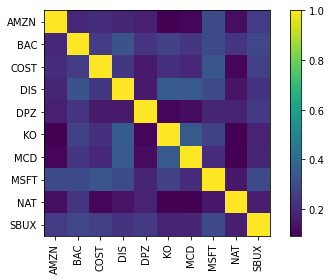

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.188218
BAC     0.109651
COST    0.077030
DIS     0.099670
DPZ     0.048853
KO      0.064524
MCD     0.069355
MSFT    0.134435
NAT     0.053297
SBUX    0.082347
dtype: float64

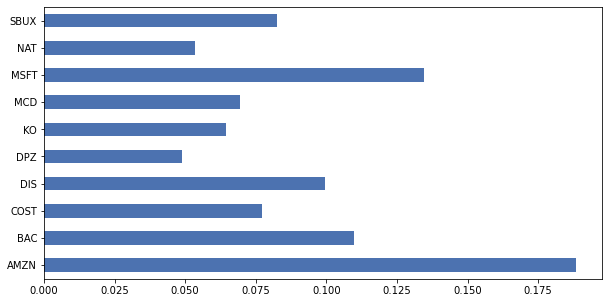

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

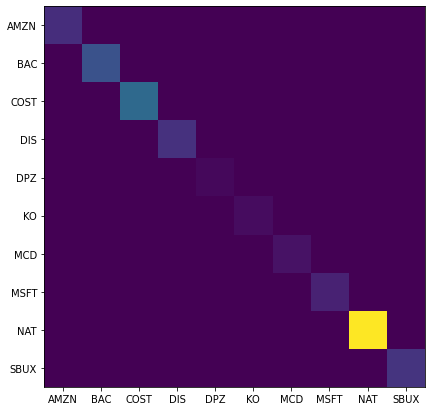

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.00457672, 0.00896382, 0.01209247, 0.00497876, 0.00080883,
       0.001164  , 0.00174691, 0.00344349, 0.03537871, 0.0053758 ])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.161776
BAC     0.139141
COST    0.061250
DIS     0.075331
DPZ     0.102268
KO      0.007673
MCD     0.104530
MSFT    0.102882
NAT     0.061824
SBUX    0.083958
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.188218,0.161776,0.10
BAC,0.109651,0.139141,0.30
COST,0.077030,0.061250,0.05
DIS,0.099670,0.075331,0.05
DPZ,0.048853,0.102268,0.20
KO,0.064524,0.007673,-0.05
MCD,0.069355,0.104530,0.15
MSFT,0.134435,0.102882,0.10
NAT,0.053297,0.061824,0.50
SBUX,0.082347,0.083958,0.10


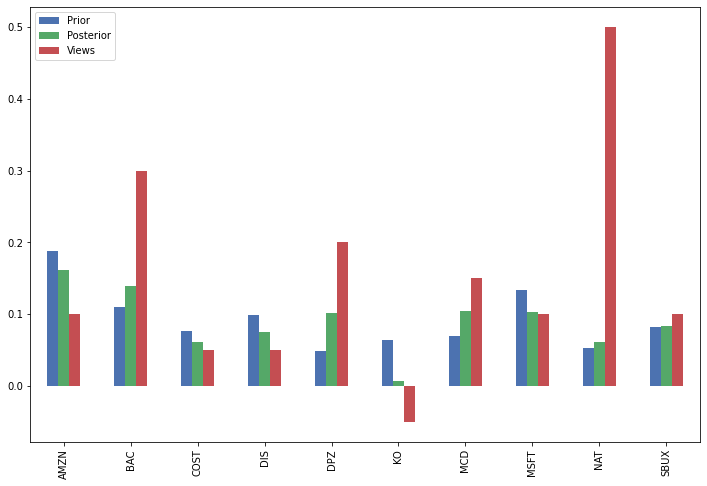

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

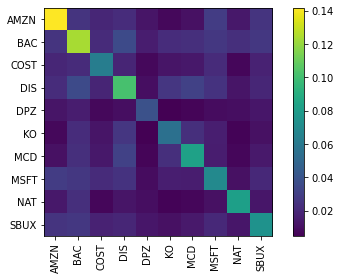

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\Victor\anaconda3\envs\aa\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.20203),
             ('BAC', 0.16638),
             ('COST', 0.05254),
             ('DIS', 0.06758),
             ('DPZ', 0.12842),
             ('KO', 0.0),
             ('MCD', 0.1235),
             ('MSFT', 0.11741),
             ('NAT', 0.05575),
             ('SBUX', 0.08639)])

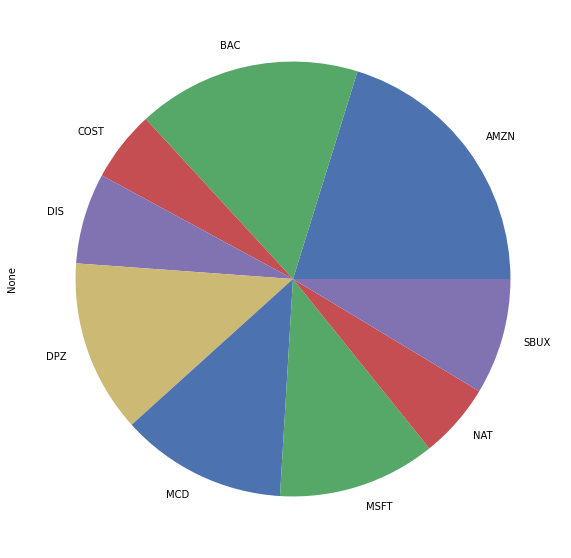

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $299.59


{'AMZN': 1,
 'BAC': 80,
 'COST': 3,
 'DIS': 8,
 'DPZ': 6,
 'MCD': 11,
 'MSFT': 10,
 'NAT': 310,
 'SBUX': 16}

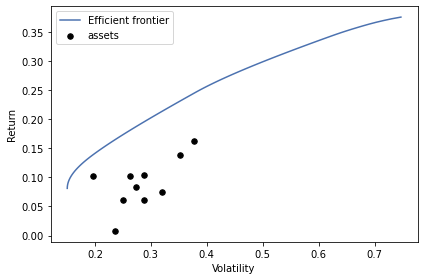

In [29]:
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

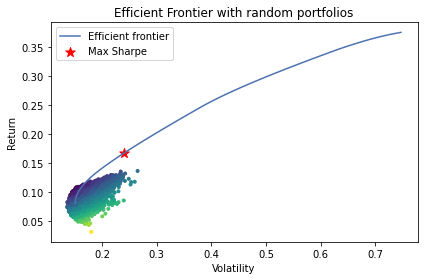

In [30]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# # Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(ret_bl)), n_samples)
rets = w.dot(ret_bl)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

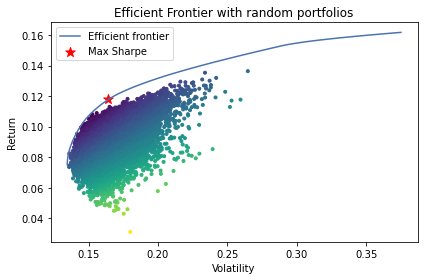

In [31]:
ef = EfficientFrontier(ret_bl, S_bl)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
